## Modules à importer

In [1]:
import math
import scipy
import pickle
import numpy as np
import pandas as pd
import iminuit as im
import ipywidgets as ipw
from snprop import age
from snprop import survey
from variaIa import tools_ar
from variaIa.tools_ar import surveys, df_cons, df_nc, df_c, df_full
from variaIa import massevol
from importlib import reload
from variaIa import stretchevol
from matplotlib.lines import Line2D
from pprint import PrettyPrinter
import matplotlib.pyplot as plt
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "EB Garamond"})
    # "axes.labelsize": 'x-large',
    # "xtick.labelsize": 'x-large',
    # "ytick.labelsize": 'x-large'})
import random

## Définitions pandas, surveys et sélection de l'échantillon à utiliser

In [2]:
def set_survey(cons, su):
    global df
    if su == 'All':
        df = df_cons(cons)
    elif 'n' in su:
        df = df_cons(cons)[df_cons(cons)['survey'] != su.split('n')[-1]]
    else:
        df = df_cons(cons)[df_cons(cons)['survey'] == su]
    return df

int_set_su = ipw.interactive(set_survey, cons=tools_ar.cons, su=tools_ar.su)
display(int_set_su)

smap = plt.cm.get_cmap('cividis')
#smap = plt.cm.get_cmap('viridis')
colors = {'SNF': plt.cm.binary(0.9),
          'low-z': (1, 0, 0),
          'SDSS': smap(0.1),
          'PS1': smap(0.5),
          'SNLS': smap(0.8),
          'HST': smap(0.99),  # for cividis
          #'HST': smap(300),  # for viridis
          'All': (255/255, 51/255, 0/255)} 

def alphacolors(alpha, survey):
    return(colors[survey][0], colors[survey][1], colors[survey][2], alpha)

df_nHST = df_nc[df_nc['survey'] != 'HST']
df_all = df_nc[df_nc['hostmass'] > 7]

interactive(children=(Checkbox(value=False, description='Conservative'), Dropdown(description='Survey:', index…

### Use SED fitted SNf data

In [3]:
sed = pd.read_csv('../../../Data/mass/SNFactory_SEDfit_Masses.txt')
sed = sed.loc[sed['name'].str.contains( 'SNF|LSQ|PTF', na=False, regex=True)]
sed = sed.rename(columns={'mass': 'hostmass', 'z': 'redshifts'})
sed['hostmass_err'] = np.sqrt((sed['mass_uppererr'].values**2 +
                               sed['mass_lowerr'].values**2)/2)
snf_df_sed = df_nc.loc[df_nc['survey'] == 'SNF'].copy()
snf_df_sed['hostmass'] = sed['hostmass'].values
snf_df_sed['hostmass_err'] = sed['hostmass_err'].values
snf_sed_nonan = snf_df_sed.loc[~np.isnan(snf_df_sed['hostmass'])]

In [4]:
df_fit = pd.concat([snf_sed_nonan,
                    df_nc[df_nc['survey'] != 'SNF']])
df_fit = df_fit[df_fit['hostmass'] > 7]
df_fit_c = pd.concat([snf_sed_nonan,
                      df_c[df_c['survey'] != 'SNF']])
df_fit_c = df_fit_c[df_fit_c['hostmass'] > 7]
df_snf = df_nc.loc[df_nc['survey'] == 'SNF']

In [14]:
np.unique(np.isnan(snf_df_sed['hostmass']), return_counts=True)

(array([False,  True]), array([110,   4]))

## Minimisation des modèles à mettre dans le _pandas_

#### SED SNF only

In [5]:
gen = massevol.generic()
gen.set_model('Evol4G4M4S')
evol4G4M4S_sed_SNF = gen.fit(snf_sed_nonan)

gen.set_model('Evol3G3M4S')
evol3G3M4S_sed_SNF = gen.fit(snf_sed_nonan)

gen.set_model('Evol3G3M3S')
LIMVAL = [None, None, (0, 1),
          None, None, None, None]
evol3G3M3S_sed_SNF = gen.fit(snf_sed_nonan, limits=None)

gen.set_model('Evol2G2M4S')
evol2G2M4S_sed_SNF = gen.fit(snf_sed_nonan)

gen.set_model('Evol2G2M3S')
evol2G2M3S_sed_SNF = gen.fit(snf_sed_nonan)

gen.set_model('Evol2G2M2S')
evol2G2M2S_sed_SNF = gen.fit(snf_sed_nonan)

gen.set_model('Evol1G1M2S')
evol1G1M2S_sed_SNF = gen.fit(snf_sed_nonan)

gen.set_model('Evol1G1M1S')
evol1G1M1S_sed_SNF = gen.fit(snf_sed_nonan)

mod_list_sed_SNF = [evol1G1M1S_sed_SNF, evol1G1M2S_sed_SNF,
                    evol2G2M2S_sed_SNF, evol2G2M3S_sed_SNF, evol2G2M4S_sed_SNF,
                    evol3G3M3S_sed_SNF, evol3G3M4S_sed_SNF, evol4G4M4S_sed_SNF]
mod_name_sed_SNF = [mod.__doc__ for mod in mod_list_sed_SNF]

pp = PrettyPrinter()
for mod in mod_list_sed_SNF:
    print(mod.__doc__)
    pp.pprint(mod.param)

/home/nicolas/.installs/anaconda3/lib/python3.7/site-packages/variaIa-0.8.4-py3.7.egg/variaIa/massevol.py:964: RuntimeWarning: invalid value encountered in log
/home/nicolas/.installs/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1761: RuntimeWarning: invalid value encountered in greater
  cond0 = self._argcheck(*args) & (scale > 0)
/home/nicolas/.installs/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1762: RuntimeWarning: invalid value encountered in greater
  cond1 = self._support_mask(x, *args) & (scale > 0)
/home/nicolas/.installs/anaconda3/lib/python3.7/site-packages/variaIa-0.8.4-py3.7.egg/variaIa/massevol.py:1014: RuntimeWarning: invalid value encountered in log


1G1M1S
{'mu': 9.82187625727687, 'sigma': 0.7456061858846675}
1G1M2S
{'mu': 10.193756826776514,
 'sigmadown': 0.9740459068452918,
 'sigmaup': 0.48906638413209524}
Howell
{'mu_1': 9.322332741309046,
 'mu_2': 10.341604804912228,
 'sigma_1': 0.5819364808339831,
 'sigma_2': 0.5095830448317993}
Howell+asym
{'mu': 10.556195468543386,
 'mu_1': 9.336563693969463,
 'sigma_1': -0.5837492861739749,
 'sigmadown': 0.7034737417633242,
 'sigmaup': 0.34260144939104675}
Howell asym
{'mu_o': 10.552824485385461,
 'mu_y': 9.246455657695117,
 'sigmad_o': 0.6988790365588977,
 'sigmad_y': 0.5272525118519866,
 'sigmau_o': 0.343872906242419,
 'sigmau_y': -0.645576679335592}
3G3M3S
{'a': 1976713.6519364933,
 'mu_1': 9.293719881514077,
 'mu_2': 41141.518959834066,
 'mu_3': -10498923.417116333,
 'sigma_1': -0.5021938337346258,
 'sigma_2': -133585.54201765225,
 'sigma_3': 126319257.14592396}
3G3M4S
{'a': 0.6218034630568389,
 'mu': 10.347660855820127,
 'mu_1': 9.342007253050884,
 'mu_2': 10.581935143253347,
 'sigma_

## Get proba

In [53]:
def get_proba_sed_SNF(model):
    # return np.exp((evol2G2M3S.get_aic() - model.get_aic())/2)
    return np.exp((evol2G2M2S_sed_SNF.get_aic() - model.get_aic())/2)

## Comparison dataframe

In [54]:
# modèles = [evol2G2M3S, evol2G2M2S,
#            evol2G2M4S, evol4G4M4S, evol3G3M4S,
#            evol3G3M3S, evol1G1M2S, evol1G1M1S]

modèles = [evol2G2M2S_sed_SNF, #evol3G3M4S,
           evol2G2M3S_sed_SNF, #evol4G4M4S,
           evol2G2M4S_sed_SNF,
           #evol3G3M3S,
           #evol1G1M2S_sed_SNF, evol1G1M1S_sed_SNF
          ]

d_mod_comp = pd.DataFrame({'Name': [k.__doc__ for k in modèles],
                           'Fixed': [k.FIXED for k in modèles],
                           'Free param': [len(k.FREEPARAMETERS) for k in modèles],
                           '$\mathcal{L}$': [round(k.get_logl(),1) for k in modèles],
                           'AIC': [round(k.get_aic(),1) for k in modèles],
                           #'$\Delta$ AIC': [round(evol2G2M3S.get_aic()-k.get_aic(),1) for k in modèles],
                           '$\Delta$ AIC': [round(evol2G2M2S_sed_SNF.get_aic()-
                                                  k.get_aic(),1) for k in modèles],
                           'Proba': [get_proba_sed_SNF(k) for k in modèles]
                          })

path = '../../../Data/tables/mass_comp/mass_df_snf-sed_comp-nobug'
if tools_ar.cons.value:
    path += '_cons'
path += '.dat'
d_mod_comp.to_csv(path)

d_mod_comp

,Name,Fixed,Free param,$\mathcal{L}$,AIC,$\Delta$ AIC,Proba
0,Howell,False,4,223.9,231.9,0.0,1.000000
1,Howell+Asym,False,5,221.4,231.4,0.6,1.319627
2,Howell asym,False,6,221.3,233.3,-1.4,0.506638


#### SNF only

In [6]:
gen = massevol.generic()
gen.set_model('Evol4G4M4S')
evol4G4M4S_SNF = gen.fit(df_snf)

gen.set_model('Evol3G3M4S')
evol3G3M4S_SNF = gen.fit(df_snf)

gen.set_model('Evol3G3M3S')
LIMVAL = [None, None, (0, 1),
          None, None, None, None]
evol3G3M3S_SNF = gen.fit(df_snf, limits=None)

gen.set_model('Evol2G2M4S')
evol2G2M4S_SNF = gen.fit(df_snf)

gen.set_model('Evol2G2M3S')
evol2G2M3S_SNF = gen.fit(df_snf)

gen.set_model('Evol2G2M2S')
evol2G2M2S_SNF = gen.fit(df_snf)

gen.set_model('Evol1G1M2S')
evol1G1M2S_SNF = gen.fit(df_snf)

gen.set_model('Evol1G1M1S')
evol1G1M1S_SNF = gen.fit(df_snf)

mod_list_SNF = [evol1G1M1S_SNF, evol1G1M2S_SNF,
                evol2G2M2S_SNF, evol2G2M3S_SNF, evol2G2M4S_SNF,
                evol3G3M3S_SNF, evol3G3M4S_SNF, evol4G4M4S_SNF]
mod_name_SNF = ['Evol'+mod.__doc__ for mod in mod_list_SNF]

pp = PrettyPrinter()
for mod in mod_list_SNF:
    print(mod.__doc__)
    pp.pprint(mod.param)

/home/nicolas/.installs/anaconda3/lib/python3.7/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/nicolas/.installs/anaconda3/lib/python3.7/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


1G1M1S
{'mu': 9.899600471027695, 'sigma': 0.8166446199117832}
1G1M2S
{'mu': 10.495397752090653,
 'sigmadown': 1.1581100938321138,
 'sigmaup': 0.41670747797498214}
Howell
{'mu_1': 9.355305744812112,
 'mu_2': 10.582100892823973,
 'sigma_1': 0.6433441309399807,
 'sigma_2': -0.3839343925296697}
Howell+asym
{'mu': 10.676200755120735,
 'mu_1': 9.368589263375236,
 'sigma_1': -0.6535418633612555,
 'sigmadown': 0.5400370303603267,
 'sigmaup': 0.34913561285685973}
Howell asym
{'mu_o': 10.683466927082339,
 'mu_y': 9.469159807651781,
 'sigmad_o': 0.5534234596133718,
 'sigmad_y': 0.7136947945293897,
 'sigmau_o': 0.3468395051932665,
 'sigmau_y': 0.5924136828861535}
3G3M3S
{'a': 0.9025777523038084,
 'mu_1': 9.42426512116249,
 'mu_2': 10.59297892851153,
 'mu_3': 8.744824893848087,
 'sigma_1': 0.6350972666001241,
 'sigma_2': 0.373869507483945,
 'sigma_3': 0.42851250949106007}
3G3M4S
{'a': 2.42953408801679,
 'mu': 11.031865368893449,
 'mu_1': 9.35731270646204,
 'mu_2': 9.277746020971291,
 'sigma_1': 0.5

## Get proba

In [40]:
def get_proba_SNF(model):
    # return np.exp((evol2G2M3S.get_aic() - model.get_aic())/2)
    return np.exp((evol2G2M3S_SNF.get_aic() - model.get_aic())/2)

## Comparison dataframe

In [41]:
# modèles = [evol2G2M3S, evol2G2M2S,
#            evol2G2M4S, evol4G4M4S, evol3G3M4S,
#            evol3G3M3S, evol1G1M2S, evol1G1M1S]

modèles = [evol2G2M2S_SNF, #evol3G3M4S,
           evol2G2M3S_SNF, #evol4G4M4S,
           evol2G2M4S_SNF,
           #evol3G3M3S,
           #evol1G1M2S_SNF, evol1G1M1S_SNF
          ]

d_mod_comp = pd.DataFrame({'Name': [k.__doc__ for k in modèles],
                           'Fixed': [k.FIXED for k in modèles],
                           'Free param': [len(k.FREEPARAMETERS) for k in modèles],
                           '$\mathcal{L}$': [round(k.get_logl(),1) for k in modèles],
                           'AIC': [round(k.get_aic(),1) for k in modèles],
                           #'$\Delta$ AIC': [round(evol2G2M3S.get_aic()-k.get_aic(),1) for k in modèles],
                           '$\Delta$ AIC': [round(evol2G2M2S_SNF.get_aic()-
                                                  k.get_aic(),1) for k in modèles],
                           'Proba': [get_proba_SNF(k) for k in modèles]
                          })

path = '../../../Data/tables/mass_comp/mass_df_snf_comp-nobug'
if tools_ar.cons.value:
    path += '_cons'
path += '.dat'
d_mod_comp.to_csv(path)

d_mod_comp

,Name,Fixed,Free param,$\mathcal{L}$,AIC,$\Delta$ AIC,Proba
0,Howell,False,4,230.0,238.0,0.0,2.464212
1,Howell+Asym,False,5,229.8,239.8,-1.8,1.000000
2,Howell asym,False,6,229.7,241.7,-3.7,0.386385


#### All samples combined with SED SNF

In [7]:
gen = massevol.generic()
gen.set_model('Evol4G4M4S')
LIMVAL = [(0, 1), None, None, None, None,
          (0, 1), None, None, None, None]
evol4G4M4S_sed = gen.fit(df_fit, limits=LIMVAL)

gen.set_model('Evol3G3M4S')
LIMVAL = [None, None, (0, 1),
          None, None, None, None, None]
evol3G3M4S_sed = gen.fit(df_fit, limits=LIMVAL)

gen.set_model('Evol3G3M3S')
LIMVAL = [None, None, (0, 1),
          None, None, (5, 15), (-1, 1)]
evol3G3M3S_sed = gen.fit(df_fit, limits=LIMVAL)

gen.set_model('Evol2G2M4S')
evol2G2M4S_sed = gen.fit(df_fit, limits=None)

gen.set_model('Evol2G2M3S')
evol2G2M3S_sed = gen.fit(df_fit, limits=None)

gen.set_model('Evol2G2M2S')
evol2G2M2S_sed = gen.fit(df_fit, limits=None)

gen.set_model('Evol1G1M2S')
evol1G1M2S_sed = gen.fit(df_fit, limits=None)

gen.set_model('Evol1G1M1S')
evol1G1M1S_sed = gen.fit(df_fit, limits=None)

mod_list_sed = [evol1G1M1S_sed, evol1G1M2S_sed,
                evol2G2M2S_sed, evol2G2M3S_sed, evol2G2M4S_sed,
                evol3G3M3S_sed, evol3G3M4S_sed, evol4G4M4S_sed]
mod_name_sed = ['Evol'+mod.__doc__ for mod in mod_list_sed]

pp = PrettyPrinter()
for mod in mod_list_sed:
    print(mod.__doc__)
    pp.pprint(mod.param)

1G1M1S
{'mu': 10.11596049193267, 'sigma': 0.7999054049383606}
1G1M2S
{'mu': 10.537053905997043,
 'sigmadown': 1.0578654652930064,
 'sigmaup': 0.5270579677127994}
Howell
{'mu_1': 9.62642956347428,
 'mu_2': 10.72986062488843,
 'sigma_1': 0.7026103217942373,
 'sigma_2': -0.4282028272333765}
Howell+asym
{'mu': 10.803467578038184,
 'mu_1': 9.645823606766768,
 'sigma_1': 0.7171798263930571,
 'sigmadown': -0.5210929405781122,
 'sigmaup': 0.39183090816099775}
Howell asym
{'mu_o': 10.738512811711528,
 'mu_y': 9.340547224392175,
 'sigmad_o': 0.493226176019227,
 'sigmad_y': 0.5184903014935405,
 'sigmau_o': 0.4067547467988055,
 'sigmau_y': 0.9602041454268972}
3G3M3S
{'a': 0.9436836617435239,
 'mu_1': 9.697674818505337,
 'mu_2': 10.733763966183679,
 'mu_3': 9.12774986155939,
 'sigma_1': 0.7334754770671146,
 'sigma_2': 0.41828274066337995,
 'sigma_3': -4.0571971230101e-06}
3G3M4S
{'a': 0.8485074700256083,
 'mu': 9.087099414131357,
 'mu_1': 9.716592988438087,
 'mu_2': 10.775313548385725,
 'sigma_1': 

## Get proba

In [48]:
def get_proba_sed(model):
    # return np.exp((evol2G2M3S.get_aic() - model.get_aic())/2)
    return np.exp((evol2G2M2S_sed.get_aic() - model.get_aic())/2)

## Comparison dataframe

In [50]:
# modèles = [evol2G2M3S, evol2G2M2S,
#            evol2G2M4S, evol4G4M4S, evol3G3M4S,
#            evol3G3M3S, evol1G1M2S, evol1G1M1S]

modèles = [evol2G2M2S_sed, #evol3G3M4S,
           evol2G2M3S_sed, #evol4G4M4S,
           evol2G2M4S_sed,
           #evol3G3M3S,
           #evol1G1M2S_sed, evol1G1M1S_sed
          ]

d_mod_comp = pd.DataFrame({'Name': [k.__doc__ for k in modèles],
                           'Fixed': [k.FIXED for k in modèles],
                           'Free param': [len(k.FREEPARAMETERS) for k in modèles],
                           '$\mathcal{L}$': [round(k.get_logl(),1) for k in modèles],
                           'AIC': [round(k.get_aic(),1) for k in modèles],
                           #'$\Delta$ AIC': [round(evol2G2M3S.get_aic()-k.get_aic(),1) for k in modèles],
                           '$\Delta$ AIC': [round(evol2G2M2S_sed.get_aic()-
                                                  k.get_aic(),1) for k in modèles],
                           'Proba': [get_proba_sed(k) for k in modèles]
                          })

path = '../../../Data/tables/mass_comp/mass_df_sed-all_comp-nobug'
if tools_ar.cons.value:
    path += '_cons'
path += '.dat'
d_mod_comp.to_csv(path)

d_mod_comp

,Name,Fixed,Free param,$\mathcal{L}$,AIC,$\Delta$ AIC,Proba
0,Howell,False,4,1546.6,1554.6,0.0,1.000000
1,Howell+Asym,False,5,1546.5,1556.5,-1.9,0.394853
2,Howell asym,False,6,1538.7,1550.7,4.0,7.327767


#### All samples combined with regular SNF

In [8]:
gen = massevol.generic()
gen.set_model('Evol4G4M4S')
LIMVAL = [(0, 1), None, None, None, None,
          (0, 1), None, None, None, None]
evol4G4M4S = gen.fit(df_all, limits=LIMVAL)

gen.set_model('Evol3G3M4S')
LIMVAL = [None, None, (0, 1),
          None, None, None, None, None]
evol3G3M4S = gen.fit(df_all, limits=LIMVAL)

gen.set_model('Evol3G3M3S')
LIMVAL = [None, None, (0, 1),
          None, None, (5, 15), (-3, 3)]
evol3G3M3S = gen.fit(df_all, limits=LIMVAL)

gen.set_model('Evol2G2M4S')
evol2G2M4S = gen.fit(df_all, limits=None)

gen.set_model('Evol2G2M3S')
evol2G2M3S = gen.fit(df_all, limits=None)

gen.set_model('Evol2G2M2S')
evol2G2M2S = gen.fit(df_all, limits=None)

gen.set_model('Evol1G1M2S')
evol1G1M2S = gen.fit(df_all, limits=None)

gen.set_model('Evol1G1M1S')
evol1G1M1S = gen.fit(df_all, limits=None)

mod_list = [evol1G1M1S, evol1G1M2S,
            evol2G2M2S, evol2G2M3S, evol2G2M4S,
            evol3G3M3S, evol3G3M4S, evol4G4M4S]
mod_name = ['Evol'+mod.__doc__ for mod in mod_list]

pp = PrettyPrinter()
for mod in mod_list:
    print(mod.__doc__)
    pp.pprint(mod.param)

1G1M1S
{'mu': 10.124465562050489, 'sigma': 0.8100453331311093}
1G1M2S
{'mu': 10.632604419068128,
 'sigmadown': 1.1126306086852333,
 'sigmaup': 0.4736546335237936}
Howell
{'mu_1': 9.627026021103038,
 'mu_2': 10.759094543713362,
 'sigma_1': 0.7068326795242196,
 'sigma_2': 0.4040050078626721}
Howell+asym
{'mu': 10.747662997852716,
 'mu_1': 9.626318236068037,
 'sigma_1': 0.7064476678930907,
 'sigmadown': -0.39465497903381275,
 'sigmaup': 0.41038959172488887}
Howell asym
{'mu_o': 10.71857855997824,
 'mu_y': 9.421361020415352,
 'sigmad_o': 0.3936187900875556,
 'sigmad_y': 0.5821327334028682,
 'sigmau_o': 0.4143439546648749,
 'sigmau_y': 0.879467319176058}
3G3M3S
{'a': 0.954033504476002,
 'mu_1': 9.68539139423216,
 'mu_2': 10.762728231129415,
 'mu_3': 8.9026625212145,
 'sigma_1': 0.7170597691018403,
 'sigma_2': 0.40010431579899,
 'sigma_3': 0.39996515767879237}
3G3M4S
{'a': 0.04584885164026587,
 'mu': 10.74632039017547,
 'mu_1': 9.684298736587458,
 'mu_2': 8.904452620246662,
 'sigma_1': 0.716

## Get proba

In [62]:
def get_proba(model):
    return np.exp((evol2G2M2S.get_aic() - model.get_aic())/2)

## Comparison dataframe

In [63]:
modèles = [evol2G2M2S, #evol3G3M4S,
           evol2G2M3S, #evol4G4M4S,
           evol2G2M4S,
           #evol3G3M3S,
           #evol1G1M2S, evol1G1M1S
          ]

d_mod_comp = pd.DataFrame({'Name': [k.__doc__ for k in modèles],
                           #'Name': ['Asym Howell', 'Howell', 'Asym+Howell', 'Asymmetric', 'Gaussian'],
                           'Fixed': [k.FIXED for k in modèles],
                           'Free param': [len(k.FREEPARAMETERS) for k in modèles],
                           '$\mathcal{L}$': [round(k.get_logl(),1) for k in modèles],
                           'AIC': [round(k.get_aic(),1) for k in modèles],
                           '$\Delta$ AIC': [round(evol2G2M2S.get_aic()-
                                                  k.get_aic(),1) for k in modèles],
                           'Proba': [get_proba(k) for k in modèles]
                          })

path = '../../../Data/tables/mass_comp/mass_df_all_comp-nobug'
if tools_ar.cons.value:
    path += '_cons'
path += '.dat'
d_mod_comp.to_csv(path)

d_mod_comp

,Name,Fixed,Free param,$\mathcal{L}$,AIC,$\Delta$ AIC,Proba
0,Howell,False,4,1534.3,1542.3,0.0,1.000000
1,Howell+Asym,False,5,1534.3,1544.3,-2.0,0.370982
2,Howell asym,False,6,1531.0,1543.0,-0.7,0.719371


#### All samples combined: conservative

In [31]:
gen = massevol.generic()
gen.set_model('Evol4G4M4S')
LIMVAL = [(0, 1), None, None, None, None,
          (0, 1), None, None, None, None]
evol4G4M4S = gen.fit(df_fit_c, limits=LIMVAL)

gen.set_model('Evol3G3M4S')
LIMVAL = [None, None, (0, 1),
          None, None, None, None, None]
evol3G3M4S = gen.fit(df_fit_c, limits=LIMVAL)

gen.set_model('Evol3G3M3S')
LIMVAL = [None, None, (0, 1),
          None, None, None, None]
evol3G3M3S = gen.fit(df_fit_c, limits=LIMVAL)

gen.set_model('Evol2G2M4S')
evol2G2M4S = gen.fit(df_fit_c, limits=None)

gen.set_model('Evol2G2M3S')
evol2G2M3S = gen.fit(df_fit_c, limits=None)

gen.set_model('Evol2G2M2S')
evol2G2M2S = gen.fit(df_fit_c, limits=None)

gen.set_model('Evol1G1M2S')
evol1G1M2S = gen.fit(df_fit_c, limits=None)

gen.set_model('Evol1G1M1S')
evol1G1M1S = gen.fit(df_fit_c, limits=None)

mod_list = [evol1G1M1S, evol1G1M2S,
            evol2G2M2S, evol2G2M3S, evol2G2M4S,
            evol3G3M3S, evol3G3M4S, evol4G4M4S]
mod_name = ['Evol'+mod.__doc__ for mod in mod_list]

pp = PrettyPrinter()
for mod in mod_list:
    print(mod.__doc__)
    pp.pprint(mod.param)

1G1M1S
{'mu': 10.061956740847156, 'sigma': 0.797966431610188}
1G1M2S
{'mu': 10.452694348881847,
 'sigmadown': 1.0403288620617432,
 'sigmaup': 0.5421075373113691}
2G2M2S
{'mu_1': 9.531736147927564,
 'mu_2': 10.676939135220971,
 'sigma_1': 0.673542071774526,
 'sigma_2': 0.425578292094692}
2G2M3S
{'mu': 10.613804620330646,
 'mu_1': 9.518471961948826,
 'sigma_1': 0.661189035901086,
 'sigmadown': 0.3494543611842619,
 'sigmaup': 0.45744341464489546}
2G2M4S
{'mu_o': 10.611372513621367,
 'mu_y': 9.228812889538412,
 'sigmad_o': 0.4045112860570618,
 'sigmad_y': 0.47221188585477475,
 'sigmau_o': 0.44012730109140974,
 'sigmau_y': 0.9570778651400966}
3G3M3S
{'a': 0.9352395596013877,
 'mu_1': 9.61454510616369,
 'mu_2': 10.686444178550463,
 'mu_3': 9.12348995331905,
 'sigma_1': 0.7182177698063541,
 'sigma_2': 0.4088396462978927,
 'sigma_3': -1.5089206092805992e-05}
3G3M4S
{'a': 0.8825783288036798,
 'mu': 8.94713386373432,
 'mu_1': 9.619027755550011,
 'mu_2': 10.713409110183065,
 'sigma_1': 0.71840766

## Get proba

In [32]:
def get_proba(model):
    # return np.exp((evol4G4M4S.get_aic() - model.get_aic())/2)
    return np.exp((evol2G2M4S.get_aic() - model.get_aic())/2)

## Comparison dataframe

In [34]:
# modèles = [evol4G4M4S, evol3G3M3S,
#            evol2G2M4S, evol3G3M4S, evol2G2M2S,
#            evol2G2M3S, evol1G1M2S, evol1G1M1S]

modèles = [evol2G2M4S, #evol3G3M4S,
           evol2G2M2S, #evol4G4M4S,
           evol2G2M3S,
           #evol3G3M3S,
           evol1G1M2S, evol1G1M1S]

d_mod_comp = pd.DataFrame({#'Name': [k.__doc__ for k in modèles],
                           'Name': ['Double Howell', 'Howell', 'Asym+Howell', 'Asymmetric', 'Gaussian'],
                           'Fixed': [k.FIXED for k in modèles],
                           'Free param': [len(k.FREEPARAMETERS) for k in modèles],
                           '$\mathcal{L}$': [round(k.get_logl(),1) for k in modèles],
                           'AIC': [round(k.get_aic(),1) for k in modèles],
                           #'$\Delta$ AIC': [round(evol4G4M4S.get_aic()-k.get_aic(),1) for k in modèles],
                           '$\Delta$ AIC': [round(evol2G2M4S.get_aic()-k.get_aic(),1) for k in modèles],
                           'Proba': [get_proba(k) for k in modèles]
                          })

path = '../../../Data/tables/mass_comp/mass_df_fit_c-sed_comp-nobug'
if tools.cons.value:
    path += '_cons'
path += '.dat'
d_mod_comp.to_csv(path)

d_mod_comp

,Name,Fixed,Free param,$\mathcal{L}$,AIC,$\Delta$ AIC,Proba
0,Double Howell,False,6,1197.4,1209.4,0.0,1.000000e+00
1,Howell,False,4,1205.0,1213.0,-3.6,1.635338e-01
2,Asym+Howell,False,5,1204.8,1214.8,-5.4,6.859230e-02
3,Asymmetric,True,3,1248.6,1254.6,-45.2,1.546534e-10
4,Gaussian,True,2,1258.2,1262.2,-52.8,3.422239e-12


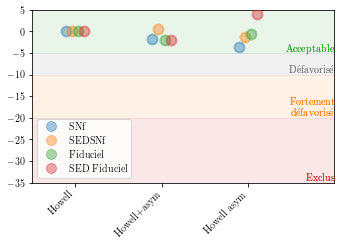

In [64]:
fig = plt.figure(figsize=[6, 4])
ax = fig.add_axes([0.15, 0.3, 0.7, 0.6])
xmax = 3

#d_mod_comp_cons = pd.read_csv('../../../Data/tables/mass_comp/mass_df_fit_c-sed_comp-nobug.dat')
d_mod_comp_snf     = pd.read_csv('../../../Data/tables/mass_comp/mass_df_snf_comp-nobug.dat')
d_mod_comp_sed_snf = pd.read_csv('../../../Data/tables/mass_comp/mass_df_snf-sed_comp-nobug.dat')
d_mod_comp_sed_all = pd.read_csv('../../../Data/tables/mass_comp/mass_df_sed-all_comp-nobug.dat')
d_mod_comp_all     = pd.read_csv('../../../Data/tables/mass_comp/mass_df_all_comp-nobug.dat')


def show_results(data_, show_text=True, show_aicc=True,
                 show_span=True, xshift=0, **kwargs):
    """ """
    if show_aicc:
        ykey = '$\Delta$ AIC'
        ylow = -35
        yscale = 'linear'
        shift = 0.95
    else:
        ykey = 'Proba'
        ylow = 1e-6
        yscale = 'log'
        shift = 1.5
    
    flag_fixed = np.asarray(data_["Fixed"], dtype="bool")
    flag_below = np.asarray(data_[ykey]<ylow, dtype="bool")
    prop = dict(marker="o", ms=10, ls="None", mew=2, zorder=8)
    prop_notfixed = {**dict(mfc="C0", mec="C0"), **kwargs}
    prop_fixed = dict(mfc="w", mec="C0")
    # above Cut
    flag = ~flag_fixed*~flag_below
    ax.plot(data_.index[flag]+xshift, data_[ykey][flag], **{**prop, **prop_notfixed})
    flag = flag_fixed*~flag_below
    ax.plot(data_.index[flag]+xshift, data_[ykey][flag],  **{**prop, **prop_fixed})
    # Below Cut
    propbelow = {**prop, **{"marker":"v", "mew":1.5, "ms":8}}
    flag = ~flag_fixed*flag_below
    ax.plot(data_.index[flag], [ylow*shift]*len(data_.index[flag]), **{**propbelow, **prop_notfixed})
    flag = flag_fixed*flag_below
    ax.plot(data_.index[flag], [ylow*shift]*len(data_.index[flag]), **{**propbelow, **prop_fixed})
    flag = flag_below
    if show_text:
        for i in data_.index[flag]:
            ax.text(i, ylow*shift**2, "%.0f"%data_.iloc[i][ykey] if show_aicc else "%.1e"%data_.iloc[i][ykey], 
                    rotation=90, color="C0", va="bottom", ha="center", fontsize="small")
    #axt.plot(data.index, data["AICc"])
    ax.set_yscale(yscale)
    
    #if not show_aicc:
    #    for i in [1,2,3,4,5]:
    #        cut = stats.norm.pdf(i, loc=0, scale=1)*2
    #        ax.axhspan(1e-20, cut, color="C1", alpha=0.1)
    #        ax.text(xmax,cut,r"$%d\sigma$"%i,va="bottom", ha="right", color="C1")
    if show_span:
        spanprop = dict(alpha=.05, lw=.5)
        textprop = dict(va="bottom", ha="right")
        # Between 1 and 2 \sigma
        ax.axhspan(5, -5, color="tab:green", **spanprop)
        ax.text(xmax, -5, r"Acceptable", color="tab:green", **textprop)
        # Between 2 and 3 \sigma
        ax.axhspan(-5, -10, color="tab:gray", **spanprop)
        ax.text(xmax, -10, r"Défavorisé", color="tab:gray", **textprop)
        # Between 3 and 5 \sigma
        ax.axhspan(-10, -20, color="tab:orange", **spanprop)
        ax.text(xmax, -20, "Fortement\n défavorisé", color="tab:orange", **textprop)
        # Between 5 and lots of \sigma
        ax.axhspan(-20, ylow, color="tab:red", **spanprop)
        ax.text(xmax, ylow, r"Exclus", color="tab:red", **textprop)
        # 
        #if not show_aicc:
        #    ax.set_ylabel(r"Model Probability ($e^{0.5\Delta\mathrm{AIC}}$)")
        #else:
        #    ax.set_ylabel(r'$\Delta\mathrm{AIC}$')
    return(ylow)

ylow = show_results(d_mod_comp_snf, alpha=.4, xshift=-0.105,
                    mfc='C0', mec='C0')
ylow = show_results(d_mod_comp_sed_snf, alpha=.4, xshift=-0.035,
                    show_text=False,
                    mfc='C1', mec='C1')
ylow = show_results(d_mod_comp_all, alpha=.4, xshift=+0.035,
                    show_text=False, show_span=False,
                    mfc='C2', mec='C2')
ylow = show_results(d_mod_comp_sed_all, alpha=.4, xshift=+0.105,
                    show_text=False, show_span=False,
                    mfc='C3', mec='C3')

ax.set_xticks(d_mod_comp_snf.index)
ax.set_xticklabels([d_mod_comp_snf.iloc[i]["Name"] for i in d_mod_comp_snf.index], rotation=45, 
                   fontdict=dict(ha="right"))

ax.set_ylim(ylow, 5)
ax.set_xlim(-0.5, xmax)

snfleg = Line2D([0], [0],
                marker='o', ms=10,
                color='C0', alpha=.4, linewidth=0)
sedsnfleg = Line2D([0], [0],
                   marker='o', ms=10,
                   color='C1', alpha=.4, linewidth=0)
allleg = Line2D([0], [0],
                marker='o', ms=10,
                color='C2', alpha=.4, linewidth=0)
sedallleg = Line2D([0], [0],
                   marker='o', ms=10,
                   color='C3', alpha=.4, linewidth=0)

handles = [snfleg, sedsnfleg, allleg, sedallleg]
labels = ['SNf', 'SEDSNf', 'Fiduciel', 'SED Fiduciel']

ax.legend(handles, labels)
          #loc='upper center', fontsize='medium', ncol=5,
          #bbox_to_anchor=(0.5, 1.0, 0.0, 0.15))

fig.savefig('../../../Images/pdf/mass_comp_df-nobug.pdf', bbox_inches='tight')
fig.savefig('../../../Images/png/mass_comp_df-nobug.png', bbox_inches='tight', dpi=600)